In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sage import MarginalImputer, PermutationEstimator

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from oob_methods import compute_oob_fis
from data_generator import generate_gaussian_causal_network
from utils import (
    compute_markov_blanket_detection_rates,
    create_comparative_boxplot,
    analyze_random_feature_importance,
    plot_random_feature_distributions,
)

In [2]:
# We will consider the following DAG (arrows are directed downwards):
#           x_0
#            |
#       x_1 x_2
#    x_3  \  | \
#      \   \ |  \
#       x_4 x_5  x_6
#         \ /
#         x_7    x_8
# x_5 will be the target. Its Markov Blanket is (x_1, x_2, x_4, x_7) so we want these
# features to receive the highest importance.
# The only non zero weights will be w_2,0 ; w_4,3 ; w_5,1 ; w_5,2 ; w_6,2 ; w_7,4 ; w_7,5
# We choose arbitrary values for the weight, bias and variance terms and therefore define:

#             x0  x1 x2 x3 x4 x5  x6 x7 x8
b = np.array([1, -1, 0, 2, 1, 2, -2, 3, 5])

#              x0   x1   x2   x3   x4   x5   x6   x7   x8
v = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

w = np.array(
    [
        # x0   x1   x2   x3   x4   x5   x6   x7   x8
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x0
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x1
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x2
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x3
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x4
        [0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x5
        [0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x6
        [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0],  # x7
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # x8
    ]
)

n_feature = len(b) - 1
idx_target = 5
idx_features = [i for i in range(n_feature + 1) if i != idx_target]
rng = np.random.RandomState(42)

# Evaluate feature selection capabilities

In [3]:
n_simulations = 50
train_size, test_size = (500, 500)
n_estimators = 50

mdi_res = dict()
ufi_res = dict()
mdi_oob_res = dict()
naive_oob_res = dict()
oob_score_res = dict()
sage_res = dict()
permut_res = dict()

for sim in range(n_simulations):
    Xy, mu, Sigma = generate_gaussian_causal_network(
        n_sample=train_size + test_size,
        b=b,
        v=v,
        w=w,
        random_state=rng,
    )
    X, y = Xy[:, idx_features], Xy[:, idx_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=rng
    )

    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        oob_score=True,
        n_jobs=-1,
        random_state=rng,
    ).fit(X_train, y_train)

    mdi_res[sim] = regressor._unnormalized_feature_importances
    feature_importance_res = compute_oob_fis(
        regressor,
        X_train,
        y_train,
        mean_squared_error,
        ["UFI", "MDI-oob", "oob-score", "naive-oob"],
    )
    ufi_res[sim] = feature_importance_res["UFI"]
    mdi_oob_res[sim] = feature_importance_res["MDI-oob"]
    oob_score_res[sim] = feature_importance_res["oob-score"]
    naive_oob_res[sim] = feature_importance_res["naive-oob"]

    imputer = MarginalImputer(regressor, X_test)
    estimator = PermutationEstimator(imputer, "mse", random_state=rng)
    sage_res[sim] = estimator(X_test, y_test, thresh=0.1, bar=False).values

    permut_res[sim] = permutation_importance(
        regressor, X_test, y_test, n_repeats=5, random_state=rng
    ).importances_mean


In [4]:
# Analyze all methods
markov_blanket_features = [1, 2, 4, 7]  # Original feature indices
# Note: These correspond to importance indices [1, 2, 4, 6] since feature 5 is target
methods = {
    "MDI": mdi_res,
    "naive-oob": naive_oob_res,
    "UFI": ufi_res,
    "MDI-OOB": mdi_oob_res,
    "oob-score": oob_score_res,
    "Permutation": permut_res,
    "SAGE": sage_res,
}

print("Markov Blanket Detection Results")
print("=" * 50)
print(f"Target Markov Blanket: Features {markov_blanket_features}")
print(f"Total Simulations: {n_simulations}")
print()

results_summary = {}

for method_name, results_dict in methods.items():
    success_count, total_sims, success_rate = compute_markov_blanket_detection_rates(
        results_dict, method_name, markov_blanket_features
    )

    results_summary[method_name] = {
        "success_count": success_count,
        "total_simulations": total_sims,
        "success_rate": success_rate,
    }

    print(
        f"{method_name:12} | Found MB: {success_count:2d}/{total_sims:2d} times ({success_rate:6.1%})"
    )

# Summary statistics
print("\n" + "=" * 50)
print("SUMMARY:")
best_method = max(
    results_summary.keys(), key=lambda x: results_summary[x]["success_rate"]
)
worst_method = min(
    results_summary.keys(), key=lambda x: results_summary[x]["success_rate"]
)

print(
    f"Best performing method:  {best_method} ({results_summary[best_method]['success_rate']:.1%})"
)
print(
    f"Worst performing method: {worst_method} ({results_summary[worst_method]['success_rate']:.1%})"
)

Markov Blanket Detection Results
Target Markov Blanket: Features [1, 2, 4, 7]
Total Simulations: 50

MDI          | Found MB: 30/50 times ( 60.0%)
naive-oob    | Found MB: 14/50 times ( 28.0%)
UFI          | Found MB: 31/50 times ( 62.0%)
MDI-OOB      | Found MB: 33/50 times ( 66.0%)
oob-score    | Found MB: 15/50 times ( 30.0%)
Permutation  | Found MB: 46/50 times ( 92.0%)
SAGE         | Found MB: 13/50 times ( 26.0%)

SUMMARY:
Best performing method:  Permutation (92.0%)
Worst performing method: SAGE (26.0%)


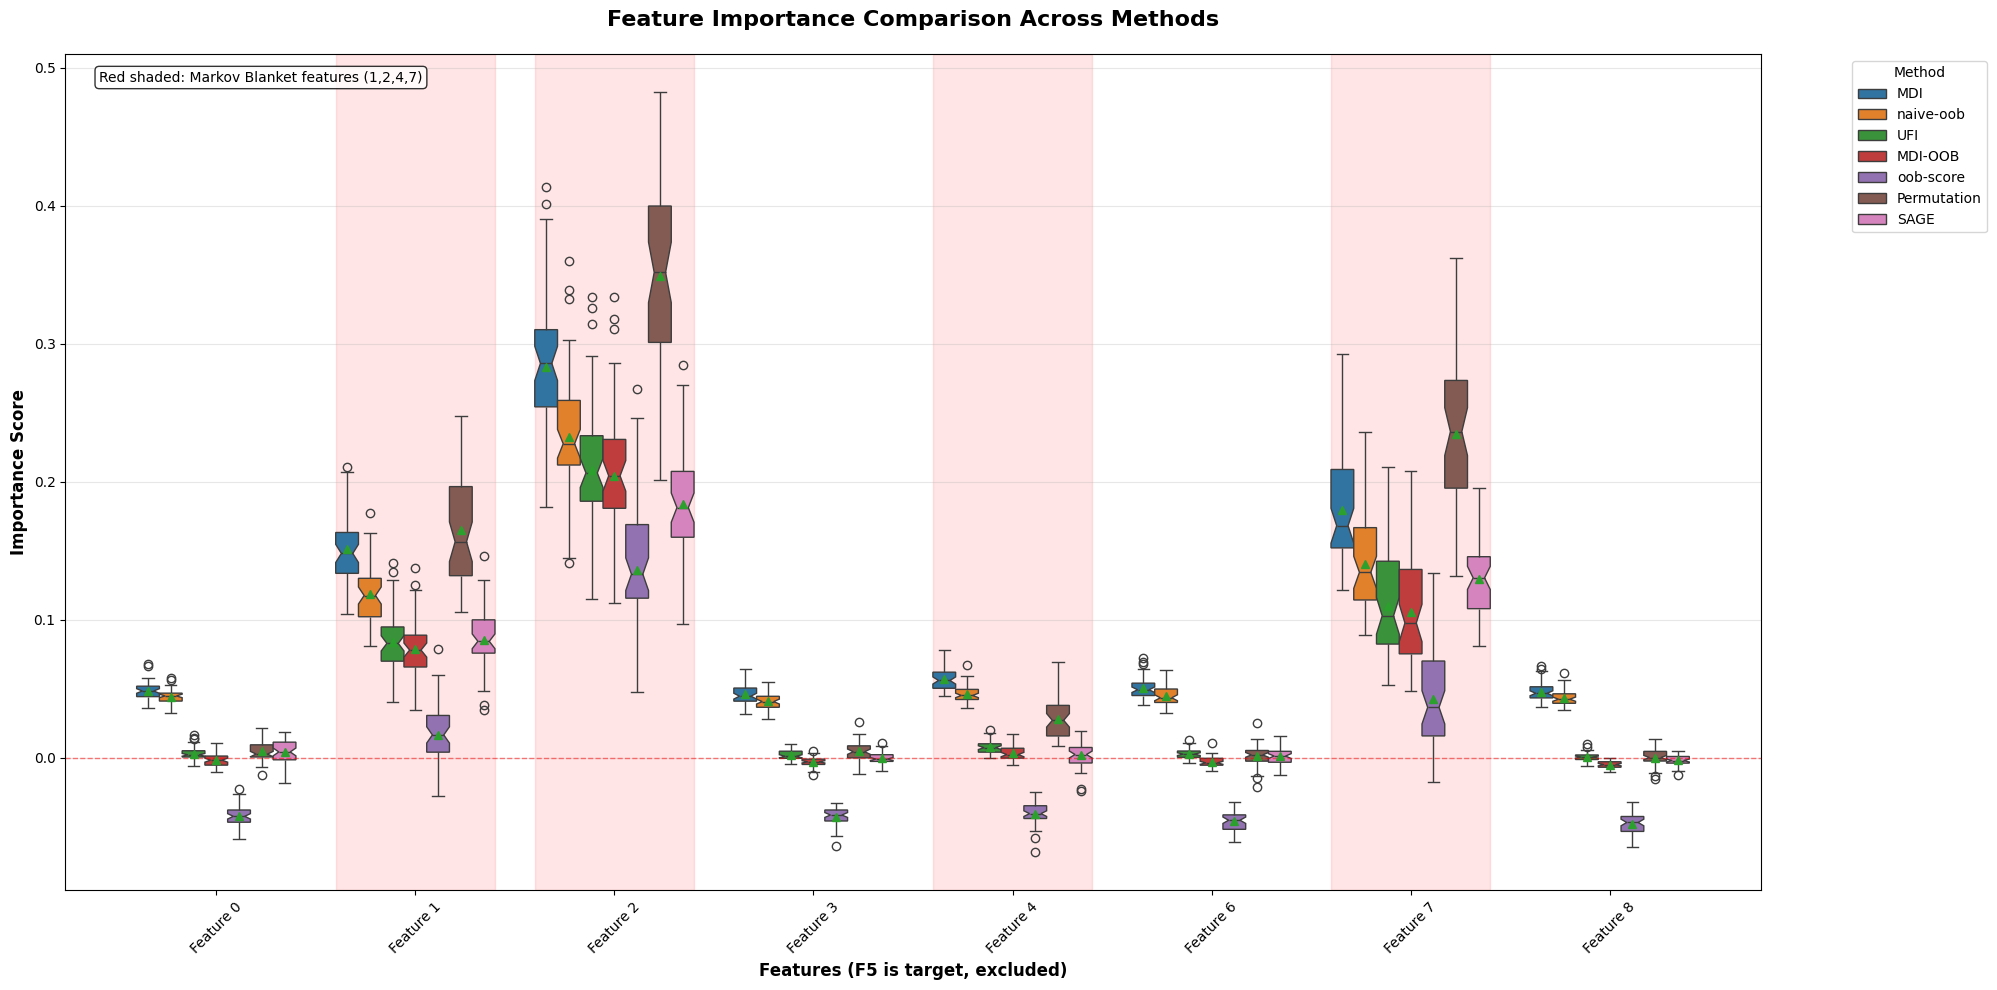

In [5]:
# Create comparative boxplot
fig1 = create_comparative_boxplot(methods, n_simulations)
plt.show()

In [6]:
# Run the analysis
random_feature_idx = 8  # Original index of random feature

# Perform statistical analysis
test_results = analyze_random_feature_importance(
    methods, random_feature_idx, alpha=0.05
)

Statistical Test for Random Feature (Index 8)
H0: Feature 8 has zero importance (mean = 0)
H1: Feature 8 has non-zero importance (mean ≠ 0)
Significance level: $\alpha$ = 0.05

MDI          | n=50 | mean=  0.0480 | std=  0.0068 | t stat= 50.084 | t-test pval= 0.0000 | Zero t-test: NO  | Wilcoxon stat=  0.000 | Wilcoxon pval= 0.0000 | Zero Wilcoxon: NO 
naive-oob    | n=50 | mean=  0.0435 | std=  0.0056 | t stat= 54.984 | t-test pval= 0.0000 | Zero t-test: NO  | Wilcoxon stat=  0.000 | Wilcoxon pval= 0.0000 | Zero Wilcoxon: NO 
UFI          | n=50 | mean=  0.0007 | std=  0.0030 | t stat=  1.604 | t-test pval= 0.1151 | Zero t-test: YES | Wilcoxon stat=484.000 | Wilcoxon pval= 0.1407 | Zero Wilcoxon: YES
MDI-OOB      | n=50 | mean= -0.0048 | std=  0.0025 | t stat=-13.517 | t-test pval= 0.0000 | Zero t-test: NO  | Wilcoxon stat=  0.000 | Wilcoxon pval= 0.0000 | Zero Wilcoxon: NO 
oob-score    | n=50 | mean= -0.0475 | std=  0.0074 | t stat=-45.525 | t-test pval= 0.0000 | Zero t-test: NO  | 

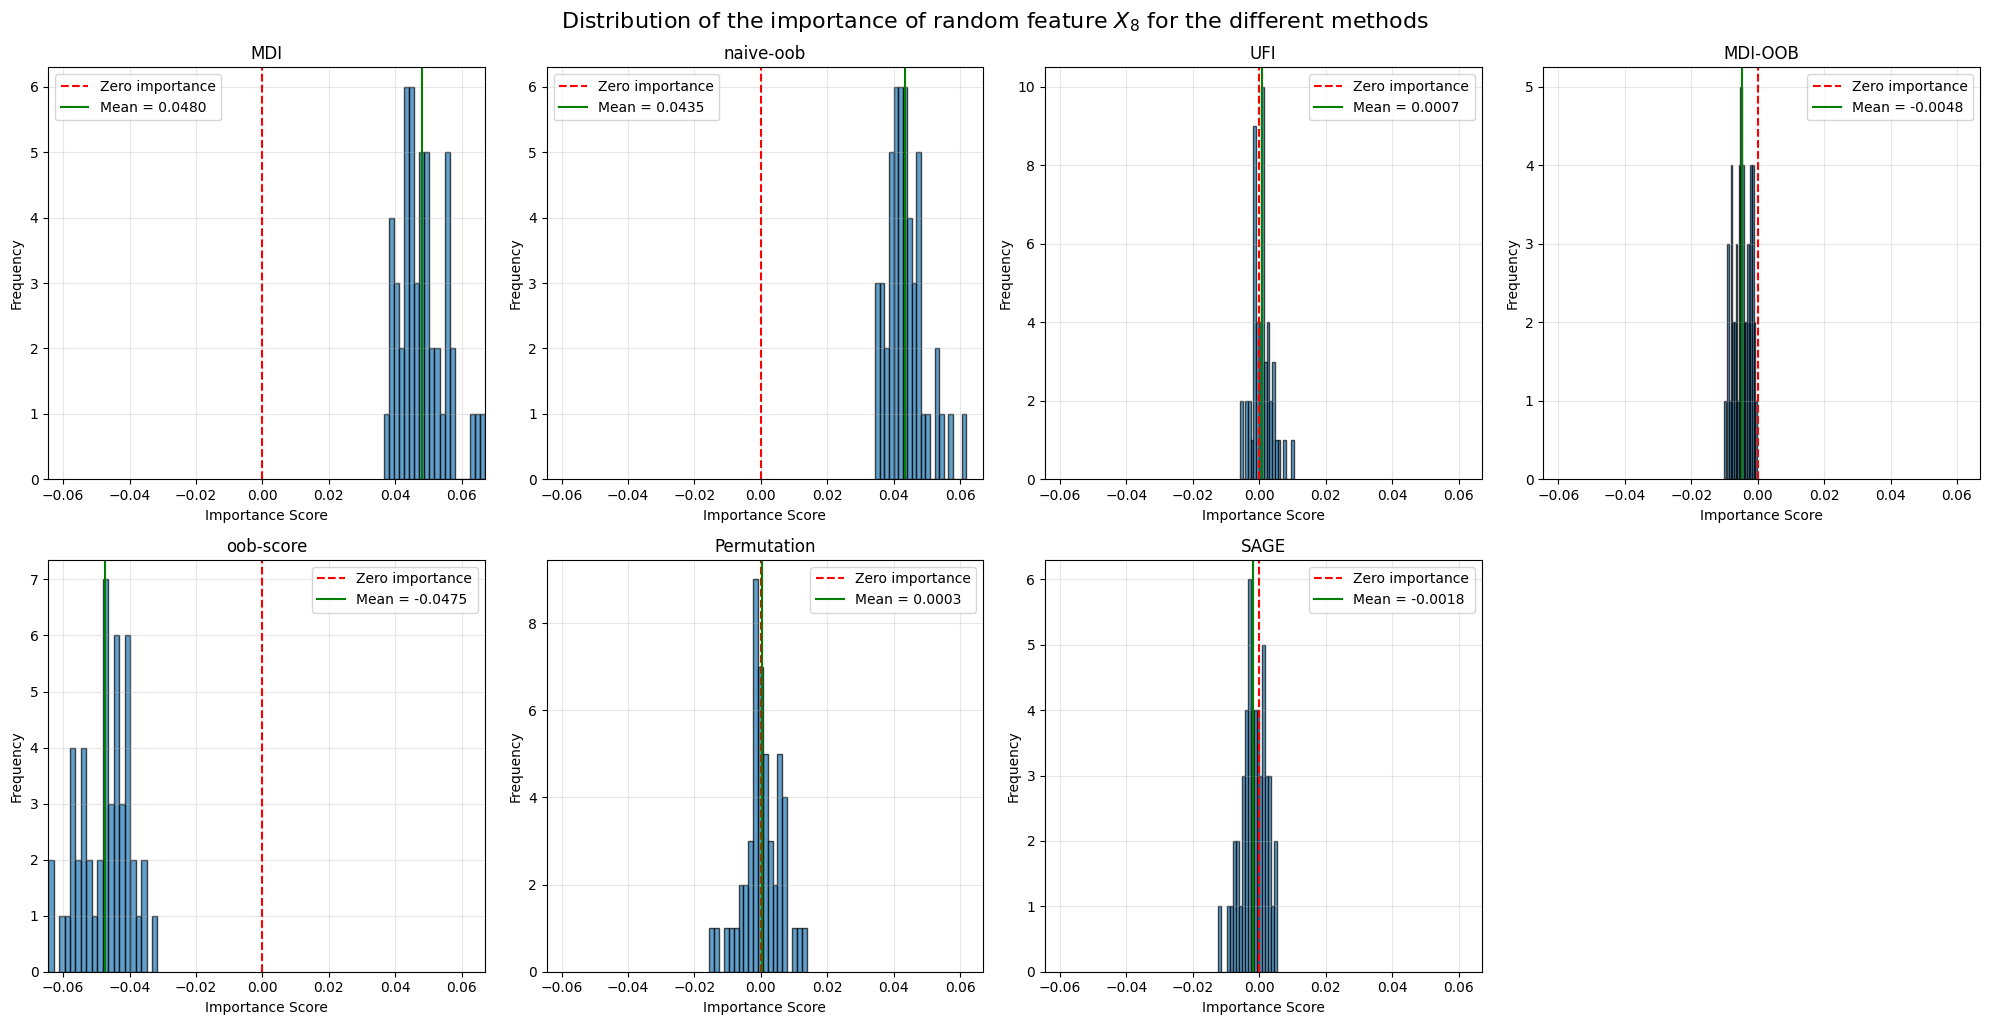

In [7]:
# Plot the distribution of the importance of randomm feature 8
fig2 = plot_random_feature_distributions(methods, random_feature_idx)
fig2.suptitle(
    f"Distribution of the importance of random feature $X_{random_feature_idx}$ for the different methods",
    fontsize=16,
    y=1.02,
)
plt.show()